<h1> How I learned to stop worrying and love uncertainty </h1>

An introductory workshop on quantifying uncertainty in building simulation.

<b>author</b>: Parag Rastogi; <b>venue</b>: CEPT University, Ahmedabad; <b>date</b>: 05-06 January, 2019.

Run each module one-by-one by either using the <kbd>run cell</kbd> button above or pressing <kbd>Ctrl + Enter</kbd> when a cell is selected. Modules like this one are `Markdown` modules, which is a kind of text-encoding language. These will not produce an output - instead you will see formatted text in the cell when you run one.


<h2>Initialisation</h2>

<ol>
<li>If you haven't read the wiki, I suggest starting <a href='https://github.com/paragrastogi/CEPT_Workshop_January2019/wiki'>there</a>. 

<li> Download the weather data given <a href='https://drive.google.com/drive/folders/15hyS_Rg-DMxu05FkoS_K-NfFdAozvgJK?usp=sharing'>here</a>. You will see three folders in there: <code>India_Amravati</code>, <code>Switzerland_Geneva</code>, and <code>India_Dehradun</code>. Download Geneva and Dehradun for this example,  placing them in the top-level directory where this script and others are located, i.e., at the same level as <code>lib</code>. For example, on my computer this file is in <code>C:\GitWorkspace\CEPT_Workshop_January2019</code>.

</ol>

Everything should work ok on a Mac, though I have only tested the exercises on Windows and Ubuntu. 

In [1]:
# First the most basic things.

# This notebook is an instance of python, sometimes called a 'kernel'.
# Any variable you declare (define, specify) here will persist until you restart the kernel.

new_variable = 2 + 3

print(new_variable)

5


In [2]:
# The variable declared above is still available here.
print(new_variable)

5


In [3]:
# There are a few different kinds of objects in python:
# 1. A number (integer or float).
new_number = 1
print(new_number)
# You can add two numbers together.
print(new_number + new_variable) # New variable is still hanging around.

# 2. A string (text).
new_string = 'lifafa'
print(new_string)
# You can add to a string or remove.
print(new_string.replace('f', 'ph'))

# 3. A list.
new_list = ['mangoes', 'watermelon', 'jamun']

# You can add to a list.
new_list.append('kaku')

# 4. A dictionary.
new_dict = dict(apples=1, oranges='tasty', bananas='bananas')
another_dict = {'apples':2, 'oranges':'bitter', 'bananas':'bananananas'}
yet_another_dict = dict(fruits=new_list, numbers=[2,8,4,6])

print('new_dict', new_dict)
print('another_dict', another_dict)
print('yet_another_dict', yet_another_dict)

1
6
lifafa
liphapha
new_dict {'apples': 1, 'oranges': 'tasty', 'bananas': 'bananas'}
another_dict {'apples': 2, 'oranges': 'bitter', 'bananas': 'bananananas'}
yet_another_dict {'fruits': ['mangoes', 'watermelon', 'jamun', 'kaku'], 'numbers': [2, 8, 4, 6]}


<h2>Scientific Programming in Python</h2> 

Python contains a lot of in-built commands but its functionality can be super-charged with external libraries or modules. The libraries I use frequently are <kbd>pandas</kbd>, <kbd>numpy</kbd>, and <kbd>sklearn</kbd>.

<h2>Types of uncertainty and exercises</h2>

The uncertainty in inputs can be separated into two types:

<ol>
    <li> Epistemic - lack of knowledge
    <li> Aleatory - inherent randomness
</ol>

In general, epistemic uncertainty can be reduced with better knowledge but aleatory cannot. Sometimes natural phenomena that appear aleatory, as in, inherently random, may not be so; it could just be that our lack of knowledge about these phenomena makes them seem random. The climate is a good example of this.

<strong>Exercise: Write down two examples of epistemic and aleatory uncertainty related to building simulation, performance, or design.</strong>

============================================================================================================

In this exercise we will use a regression model (black-box model) to estimate the response of a building. We will do an exercise related to epistemic uncertainty and one related to aleatory. The rest of the workshop is structured as follows:

<ol>
    <li> Loading python modules and weather files.
    <li> Black-box models.
    <li> Epistemic uncertainty with black-box models.
    <li> Aleatory uncertainty with black-box models.
</ol>

In [4]:
# Import various standard modules.
import glob
import os
import pickle
import copy
import datetime
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Plotting modules.
import matplotlib.pyplot as plt
# import seaborn as sns

# Get inline graphs .
%matplotlib inline

# Only useful for debugging, when you 
# need to reload external modules.
from importlib import reload

# Enable xkcd mode - if you're a nerd.
# plt.xkcd()

# Import a custom read-write function for weather files.
import wfileio as wf

# import small helpers I've written.
from petites import circ_rolling_mean
from petites import smoother

# Import an awesome colour palette. Call it colours.
import default_colours as colours

# Set the random seed to a specific value so
# the experiment is repeatable.
# See https://en.wikipedia.org/wiki/Random_seed
# for more information on what this means.
# For why I chose 42, read The Hitchhiker's Guide to the Galaxy.
np.random.seed(42)

In [5]:
# Read location data.

# We will store some metadata about the stations as well.
metadata = dict(locdata=list(), header=list())

# We will only use the EPW file format for this exercise.
file_type = 'epw'

# I use os.path.join so the paths are automatically constructed based on the OS.
path_epw_ddn = os.path.join('..', 'India_Dehradun', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')

# The small program get_weather stores data from the incoming weather
# file as a dataframe.
ddn, locdata, header = wf.get_weather('ddn', path_epw_ddn)

# Save some metadata about the location.
metadata['locdata'].append(locdata)
metadata['header'].append(header)

# Do the same with Geneva data. Except Geneva has multiple weather files, so use a loop.
path_gen_folder = os.path.join('..', 'Switzerland_Geneva', 'historical')
list_genfiles = glob.glob(os.path.join(path_gen_folder, '*.{:s}'.format(file_type)))

# Declare a list.
gen_list = list()

for file in list_genfiles:
    
    gen_temp, locdata, header = wf.get_weather('gen', file)
    gen_list.append(gen_temp)
    
# Keep the list - useful for plotting and stuff later.
gen = pd.concat(gen_list)

metadata['locdata'].append(locdata)
metadata['header'].append(header)


Found multiple years in file name, assigning 2223.
[2002 2003 2005 2006 1996 2001]
Found multiple years in file name, assigning 2223.
[1984 1982 1983 1995 1991 1993 1989 1996 1988]


In [6]:
print('DEHRADUN')

print(ddn.describe())

print('======\r\n')

print('GENEVA')

print(gen.describe())

print('======')

DEHRADUN
         year        month          day         hour  minute          tdb  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.0  8760.000000   
mean   2223.0     6.526027    15.720548    12.500000     0.0    21.406164   
std       0.0     3.448048     8.796749     6.922582     0.0     6.997080   
min    2223.0     1.000000     1.000000     1.000000     0.0     3.700000   
25%    2223.0     4.000000     8.000000     6.750000     0.0    15.900000   
50%    2223.0     7.000000    16.000000    12.500000     0.0    22.600000   
75%    2223.0    10.000000    23.000000    18.250000     0.0    26.400000   
max    2223.0    12.000000    31.000000    24.000000     0.0    38.100000   

               tdp           rh         atmpr         etrh   ...    \
count  8760.000000  8760.000000   8760.000000  8760.000000   ...     
mean     14.569361    68.816324  93246.278539   363.913242   ...     
std       6.366100    19.862185    554.094937   445.441654   ...     
min      -1.10000

In [7]:
# Calculate the monthly mean values of weather parameters for Dehradun.

relevant_keys = ['tdb']
span = 730  # About a month.

# Calculate the monthly mean of temperature for plotting.
ddn_summary = ddn.resample('1M').mean()[relevant_keys]
# Assign an index to the dataframe - useful for plotting.    
ddn_summary.index = pd.unique(ddn['month'])

# Calculate a smoothed version of the original hourly signal using a rolling mean.
ddn_smooth = circ_rolling_mean(ddn[relevant_keys])

# Do the same for Geneva.
gen_summary = list()
gen_smooth = list()
for yearlong in gen_list:
    
    temp_summary = yearlong.resample('1M').mean()[relevant_keys]
    # Assign an index to the dataframe - useful for plotting.    
    temp_summary.index = pd.unique(yearlong['month'])
    gen_summary.append(temp_summary)

    # Calculate a smoothed version of the original hourly signal using a rolling mean.
    gen_smooth.append(circ_rolling_mean(yearlong[relevant_keys]))

# # Set the variable 'tmy' to the incoming data from Dehradun - so changing 
# # this statement will allow you to run the worksheet with any location.
# tmy = ddn

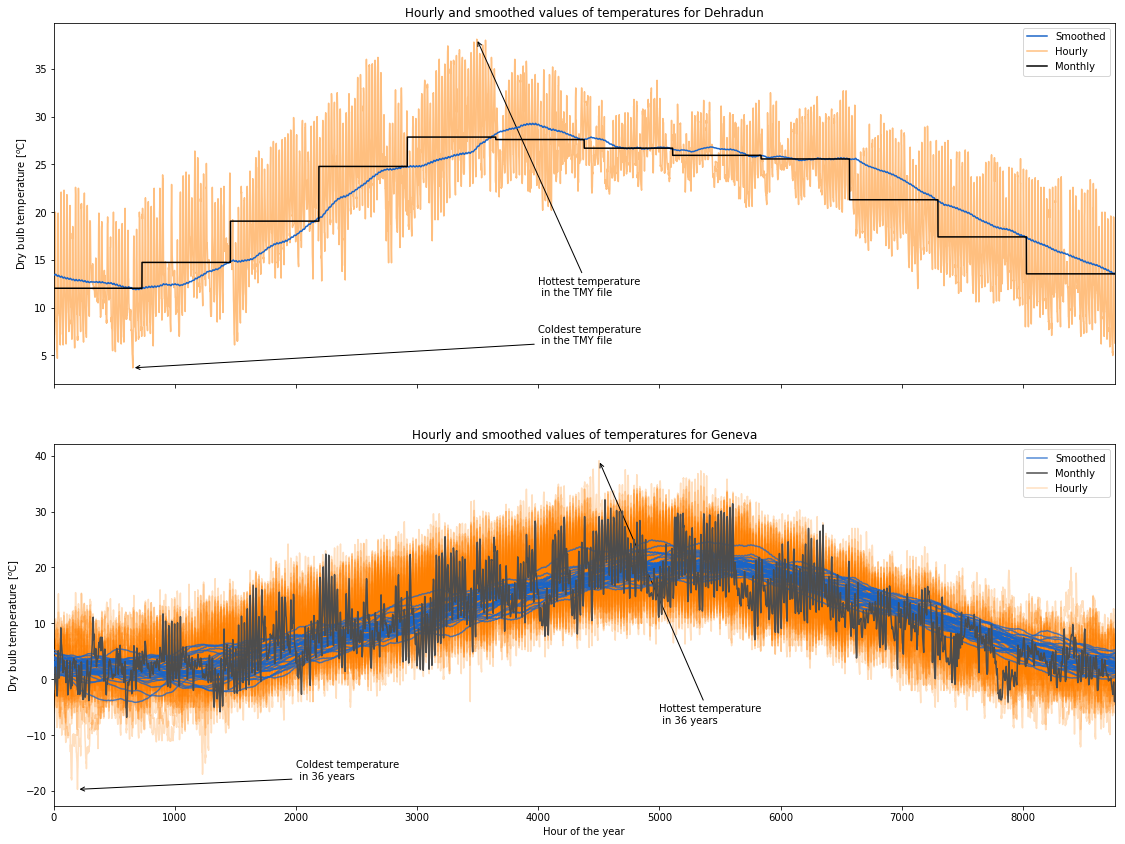

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

# Find the index and value of the max and min temperatures.
ymax = list()
ymin = list()
xmax = list()
xmin = list()

ddn_temp_vals = ddn['tdb'].values
ymax.append(np.max(ddn_temp_vals))
xmax.append(np.argmax(ddn_temp_vals))
ymin.append(np.min(ddn_temp_vals))
xmin.append(np.argmin(ddn_temp_vals))

gen_temp_vals = gen['tdb'].values
ymax.append(np.max(gen_temp_vals))
ymin.append(np.min(gen_temp_vals))

plot_x = np.arange(0, ddn.shape[0])
ax[0].plot(plot_x, ddn_smooth['tdb'].values, zorder=10, color=colours.blue)
ax[0].plot(plot_x, ddn['tdb'].values, zorder = 1, color=colours.orange, alpha=0.5)
ax[0].plot(plot_x, np.repeat(ddn_summary['tdb'], 8760/12), color=colours.blackest, zorder=11)


for raw, smooth, summary in zip(gen_list, gen_smooth, gen_summary):
    
    p1 = ax[1].plot(plot_x, smooth['tdb'], zorder=10, color=colours.blue, alpha=0.75)
    
    raw_temp_vals = raw['tdb'].values
    
    if np.unique(raw.index.year)==2223:
        p2 = ax[1].plot(plot_x, raw_temp_vals, zorder = 12, color=colours.grey)
    else:
        p3 = ax[1].plot(plot_x, raw_temp_vals, zorder = 1, color=colours.orange, alpha=0.25)
    
    if ymin[1] in raw_temp_vals:
        xmin.append(np.argmin(raw_temp_vals))
    
    if ymax[1] in raw_temp_vals:
        xmax.append(np.argmax(raw_temp_vals))

#     ax[1].plot(plot_x, np.repeat(summary['tdb'], 8760/12), color=colours.blackest, zorder=11)

for ax_temp in ax:
    ax_temp.set_ylabel('Dry bulb temperature [$^o$C]')
    ax_temp.set_xlim(plot_x[0], plot_x[-1])

ax[0].legend(['Smoothed', 'Hourly', 'Monthly'])
ax[1].legend({p1[0], p3[0], p2[0]}, {'Smoothed', 'Hourly', 'Monthly'})
ax[1].set_xlabel('Hour of the year')
ax[0].set_title('Hourly and smoothed values of temperatures for Dehradun')
ax[1].set_title('Hourly and smoothed values of temperatures for Geneva')

ax[0].annotate('Hottest temperature \n in the TMY file\n',
    xy=(xmax[0], ymax[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 10))
ax[0].annotate('Coldest temperature \n in the TMY file\n',
    xy=(xmin[0], ymin[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 5))

ax[1].annotate('Hottest temperature \n in 36 years\n',
    xy=(xmax[1], ymax[1]), arrowprops=dict(arrowstyle='->'), xytext=(5000, -10))
ax[1].annotate('Coldest temperature \n in 36 years\n',
    xy=(xmin[1], ymin[1]), arrowprops=dict(arrowstyle='->'), xytext=(2000, -20))

plt.show()


<h2> Black Box Models </h2>

A black-box model is any model (mathematical relationship) that can only be viewed in terms of its inputs and outputs. That is, we cannot "see" the inner workings or relationships that result in certain inputs giving certain outputs. It can be used to represent a physical system if sufficient data is available to characterise the relationship between the inputs and outputs of that system. In building simulation, for example, a black-box model could relate outside temperature to heating demand without any indication of <i>how</i> that demand is generated physically, i.e., without solving the equations of heat transfer.  

For this workshop, we will use <kbd>scikit-learn</kbd> (use the alias <kbd>sklearn</kbd> when installing with <kbd>pip</kbd> or <kbd>conda</kbd>), a library in python, to fit models to data obtained from energy plus simulations.  

<h2>Exercises</h2>

We will do two exercises, each linked to a different type of uncertainty: 

<ol>
<li> Epistemic uncertainty: fixed inputs, random coefficients. 
<li> Aleatory uncertainty: random inputs, fixed coefficients.
</ol>

In [9]:
# Load data from energyplus simulations.

path_data = '../sim_data/SummaryTable_BaseSimulation.csv'

df_eplus = pd.read_csv(path_data)

# Drop rows that contain infinity, negative infinity, NaN values.
df_eplus = df_eplus.dropna(how='any', axis='index')

<h2>Data</h2> 
<br>
This dataframe contains some numerical fields, which we will use in this regression exercise, and non-numerical fields, which are just labels. 

The 'outputs' are annual sum of heating and cooling loads - the dataframe contains both the raw <i>kWh</i> values and normalised values in <i>kWh/m2</i>. The inputs are all the remaining numerical fields. 

In [10]:
# Let's explore the data.

print('Columns:', df_eplus.columns.tolist())

print('Dimensions:', df_eplus.shape)

Columns: ['sim_number', 'idfname', 'wthrfolder', 'wthrsrc', 'wthrfile', 'stname', 'heating', 'cooling', 'heatnorm', 'coolnorm', 'avgsunperc', 'sumihg', 'suminfloss', 'suminfgain', 'sumwinloss', 'sumwingain', 'wfr', 'wwr', 'tmass', 'uval', 'rr', 'ff', 'azone', 'avtdb', 'medtdb', 'iqrtdb', 'mrangtdb', 'cdd', 'hdd', 'avtdp', 'medtdp', 'iqrtdp', 'sumghi', 'sumdni', 'iqrghi', 'iqrdni', 'avghi', 'avdni', 'avrh', 'medrh', 'iqrrh', 'BuildingCode', 'era', 'block', 'BuildingName']
Dimensions: (88242, 45)


<h2>Regression Models</h2>

We will define a function that takes as input the x-data (independent variables), the model type (e.g., linear), and the coefficients (optional, if known). We will write the function such that if you do not enter values for the regression coefficients, the function will attempt to fit the x-data to the given y-data.

First we split the data into two subsets, one each for <b>training</b> and <b>testing</b>. As the names suggest, we will use the first subset to 'train' the regression models, and then test the models on the second subset. A regression model needs to be trained by showing it data that is properly representative of the problem being studied. This is because the regression model does not solve the underlying physical equations; instead, it tries to mimic the behaviour of the system (building) by modelling the changes in inputs and outputs seen in a given dataset.

In [11]:
# These are columns with numerical values.
xvars = ['avgsunperc', 'sumihg', 'suminfloss', 'suminfgain', 'sumwinloss', 'sumwingain',
         'wfr', 'wwr', 'tmass', 'uval', 'rr', 'ff',
         'avtdb', 'medtdb', 'iqrtdb', 'mrangtdb', 'cdd', 'hdd', 'avtdp', 'medtdp', 'iqrtdp',
         'sumghi', 'sumdni', 'iqrghi', 'iqrdni', 'avghi', 'avdni', 'avrh', 'medrh', 'iqrrh']

# Select 50,000 random samples as training data.
train_sample = np.random.choice(df_eplus.index, 50000, replace=False)
# The rest become test samples.
test_sample = [x for x in df_eplus.index if x not in train_sample]

# Based on the sampling above, divide the dataset into subsets for training and testing.
x_train = df_eplus.loc[train_sample, xvars]
y_train = df_eplus.loc[train_sample, ['heatnorm', 'coolnorm']]
x_test = df_eplus.loc[test_sample, xvars]
y_test = df_eplus.loc[test_sample, ['heatnorm', 'coolnorm']]

print(x_train.shape)

(50000, 30)


Text(0.5, 28.0, 'y [kWh/$m^2$]')

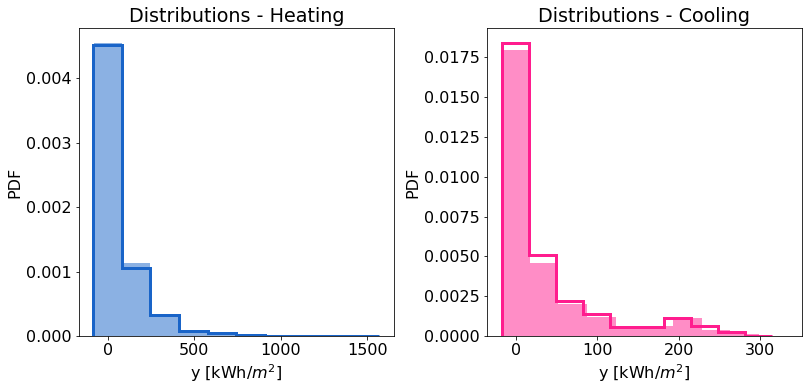

In [12]:
# Set default font properties.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=3, h_pad=5)

ax[0].hist(y_train['heatnorm'], density=True, color=colours.blue, alpha=0.5,
           align='left')
ax[0].hist(y_test['heatnorm'], density=True, color=colours.blue, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[0].set_title('Distributions - Heating')
ax[0].set_ylabel('PDF')
ax[0].set_xlabel('y [kWh/$m^2$]')

ax[1].hist(y_train['coolnorm'], density=True, color=colours.hotpink, alpha=0.5,
           align='left')
ax[1].hist(y_test['coolnorm'], density=True, color=colours.hotpink, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[1].set_title('Distributions - Cooling')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('y [kWh/$m^2$]')

In [13]:
# Define min and max to set pretty axis limits.
axmin = dict(heat=df_eplus.loc[train_sample, 'heatnorm'].min(),
             cool=df_eplus.loc[train_sample, 'coolnorm'].min())
axmax = dict(heat=df_eplus.loc[train_sample, 'heatnorm'].max().round(-2),
             cool=df_eplus.loc[train_sample, 'coolnorm'].max().round(-2))
bins = dict(heat=np.linspace(-100, 100, num=25),
            cool=np.linspace(-100, 100, num=25))

print(axmin)
print(axmax)
# print(bins)

def plot_predictions(y_test, y_pred,y_train):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 
    ax = axes.flatten()
    fig.tight_layout(pad=3, w_pad=3, h_pad=5)

    ax[0].plot(y_test['heatnorm'], y_pred['heatnorm'], color=colours.hotpink, marker='.', linewidth=0)
    ax[0].plot(y_test['heatnorm'], np.repeat(y_train['heatnorm'].mean(), y_test.shape[0]),
               color=colours.blackest, linewidth=2)
    ax[0].set_xlim(axmin['heat'], axmax['heat'])
    ax[0].set_ylim(axmin['heat'], axmax['heat'])
    ax[0].set_title('Heating')
    ax[0].set_xlabel('Simulated (E+) [kWh/$m^2$]')
    ax[0].set_ylabel('Predicted (regression) [kWh/$m^2$]')
    ax[0].legend({'Mean', 'Model'})

    ax[1].plot(y_test['coolnorm'], y_pred['coolnorm'], color=colours.blue, marker='.', linewidth=0)
    ax[1].plot(y_test['coolnorm'], np.repeat(y_train['coolnorm'].mean(), y_test.shape[0]),
               color=colours.blackest, linewidth=2)
    ax[1].set_xlim(axmin['cool'], axmax['cool'])
    ax[1].set_ylim(axmin['cool'], axmax['cool'])
    ax[1].set_title('Cooling')
    ax[1].set_xlabel('Simulated (E+) [kWh/$m^2$]')
    ax[1].set_ylabel('Predicted (regression) [kWh/$m^2$]')
    ax[1].legend({'Mean', 'Model'})
    
    ax[2].hist(y_test['heatnorm'] - y_pred['heatnorm'], bins=bins['heat'],
               density=False, color=colours.hotpink, alpha=0.5, align='left', rwidth=0.75)
    ax[2].set_title('Errors - Heating')
    ax[2].set_ylabel('Count')
    ax[2].set_xlabel('$\epsilon$ [kWh/$m^2$]')

    ax[3].hist(y_test['coolnorm'] - y_pred['coolnorm'], bins=bins['cool'],
               density=False, color=colours.blue, alpha=0.5, align='left', rwidth=0.75)
    ax[3].set_title('Errors - Cooling')
    ax[3].set_ylabel('Count')
    ax[3].set_xlabel('$\epsilon$ [kWh/$m^2$]')


{'heat': 0.0, 'cool': 0.0}
{'heat': 1600.0, 'cool': 400.0}


<h2>Single-parameter model</h2>

A model with only one parameter represents a situation where you have no idea what to expect, so it is safest to assume that the mean energy usage seen in your training data is representative of the entire population. The standard method of assessing the performance of any model is to compare it to this single-parameter model.


In [14]:
y_pred = dict()
y_pred['heatnorm'] = np.repeat(np.mean(y_train.loc[:, 'heatnorm']), y_test.loc[:, 'heatnorm'].shape[0])
y_pred['coolnorm'] = np.repeat(np.mean(y_train.loc[:, 'coolnorm']), y_test.loc[:, 'coolnorm'].shape[0])

y_pred = pd.DataFrame(y_pred)

<h2>Linear Models</h2>

For the first model, we use a linear model to specify the relationship between inputs and output. The simulators you use will almost never be linear - for buildings at least - so this sort of model will usually only work for very simple problems. 

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [95]:
model_lin_regr = dict(heatnorm=LinearRegression(), coolnorm=LinearRegression())
model_lin_regr['heatnorm'].fit(X=x_train, y=y_train['heatnorm'])
model_lin_regr['coolnorm'].fit(X=x_train, y=y_train['coolnorm'])

y_pred['heatnorm'] = model_lin_regr['heatnorm'].predict(x_test)
y_pred['coolnorm'] = model_lin_regr['coolnorm'].predict(x_test)

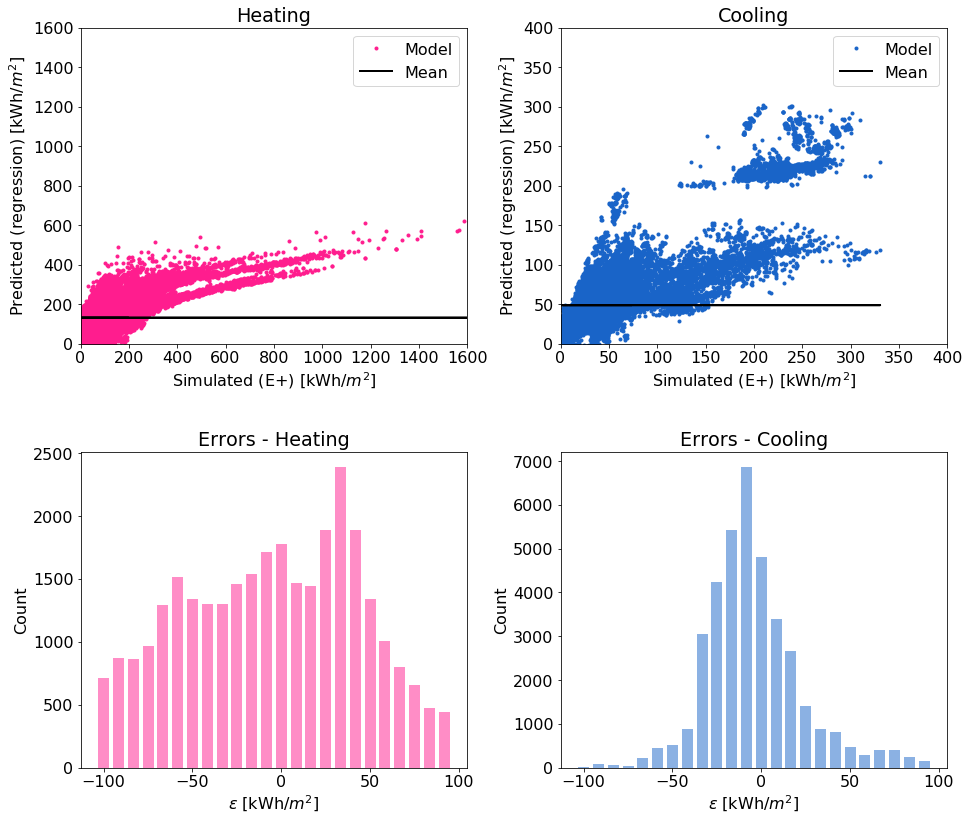

In [77]:
plot_predictions(y_test, y_pred,y_train)

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [93]:
model_poly_features = PolynomialFeatures(2)
x_train_trans = model_poly_features.fit_transform(x_train)
model_poly_regr = dict(heatnorm=LinearRegression(), coolnorm=LinearRegression())
model_poly_regr['heatnorm'].fit(X=x_train_trans, y=y_train['heatnorm'])
model_poly_regr['coolnorm'].fit(X=x_train_trans, y=y_train['coolnorm'])

x_test_trans = model_poly_features.fit_transform(x_test)
y_pred['heatnorm'] = model_poly_regr['heatnorm'].predict(x_test_trans)
y_pred['coolnorm'] = model_poly_regr['coolnorm'].predict(x_test_trans)

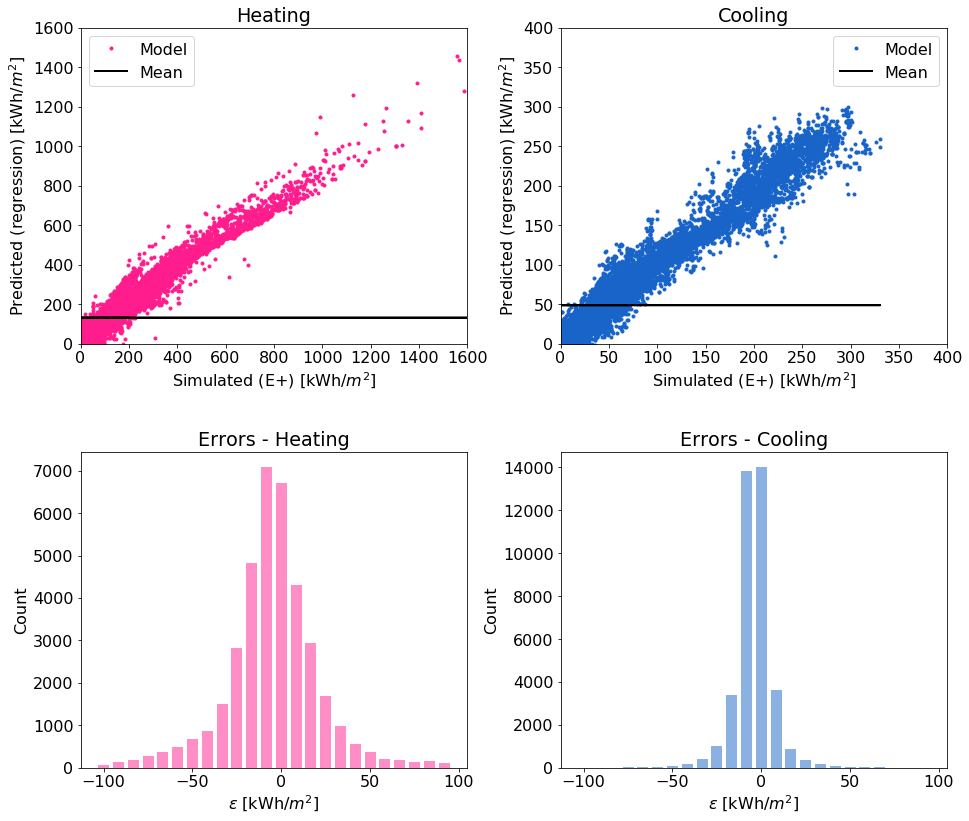

In [94]:
plot_predictions(y_test, y_pred,y_train)

In [21]:
model_poly3_features = PolynomialFeatures(3)
x_train_trans = model_poly3_features.fit_transform(x_train)
model_poly3_regr = dict(heatnorm=LinearRegression(), coolnorm=LinearRegression())
model_poly3_regr['heatnorm'].fit(X=x_train_trans, y=y_train['heatnorm'])
model_poly3_regr['coolnorm'].fit(X=x_train_trans, y=y_train['coolnorm'])

x_test_trans = model_poly3_features.fit_transform(x_test)
y_pred['heatnorm'] = model_poly3_regr['heatnorm'].predict(x_test_trans)
y_pred['coolnorm'] = model_poly3_regr['coolnorm'].predict(x_test_trans)

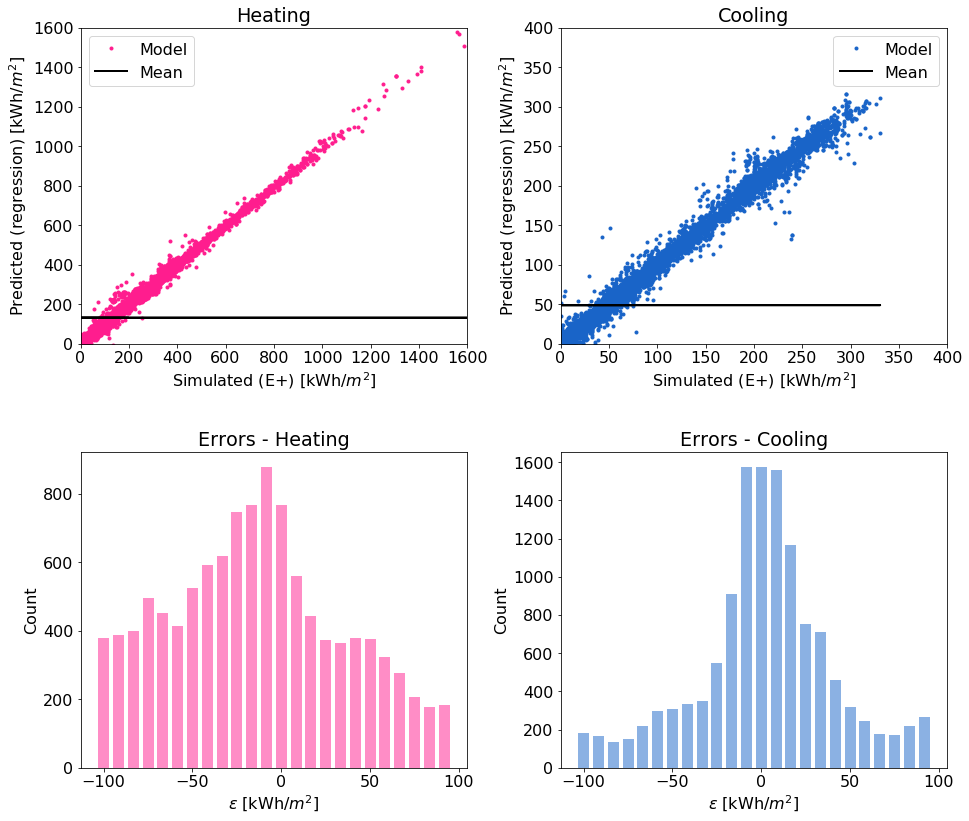

In [22]:
plot_predictions(y_test, y_pred,y_train)

<h2> Epistemic Uncertainty </h2>

<h3>Random coefficients, fixed inputs</h3>

For the first exercise, we fix the inputs to typical values and use random coefficients to specify the relationship between inputs and output. The simulators you use will almost never be random - for buildings at least - so this exercise represents a lack of knowledge about the coefficients. That is to say, <i>if we don't know the relationships, then they appear random</i>.

Remember that the coefficients represent your building's properties, and the inputs are the boundary conditions. Variation in the boundary conditions creates variation in energy and other outputs of interest (like indoor temperature).

In [65]:
# First define a function with 5 variables (to keep this exercise simple, we will use only five input variables).

def model_random_regr(load, x, model_type):
    
    beta = dict(heatnorm=None, coolnorm=None)
    
    if model_type == 'random':
        beta['heatnorm'] = np.random.rand(5)
        beta['coolnorm'] = np.random.rand(5)
        
    elif model_type == 'fixed':
        beta['heatnorm'] = [1, 1, 1, 1, 1]
        beta['coolnorm'] = [1, 1, 1, 1, 1]

    if load in ['cool', 'coolnorm']:
        y = np.sum([b*xin for b, xin in zip(beta['coolnorm'], x)])
    elif load in ['heat', 'heatnorm']:
        y = np.sum([b*xin for b,xin in zip(beta['heatnorm'], x)])
        
    return y

In [124]:
# We will use a scaler to ensure that all the inputs are of roughly the same order of magnitude. 
# This does not make much of a difference when you fit regression models like we did above,
# since the magnitudes of the coefficients match those of the features to produce the correct
# magnitude of output. 
# However, we need it here to demonstrate epistemic uncertainty.
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Work with a reduced set of independent variables (inputs, x).
selected_xvars = ['hdd', 'cdd', 'sumihg', 'suminfloss', 'suminfgain']

x_train_scaled = scaler_x.fit_transform(x_train.loc[:, selected_xvars])
x_test_scaled = scaler_x.fit_transform(x_test.loc[:, selected_xvars])

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.fit_transform(y_test)

# Scaling should transform the columns so they have mean=0 and stdev=1.
print('Scaled column means:', np.mean(x_train_scaled,axis=0))
print('Scaled column stdevs:', np.std(x_train_scaled, axis=0))

Scaled column means: [ 1.69961822e-16  7.60991270e-17  9.97602001e-17 -5.88329385e-17
 -2.78177481e-17]
Scaled column stdevs: [1. 1. 1. 1. 1.]


In [141]:
# Let the function pick any random coefficients. 
# The output will look different every time.

y_pred = np.NaN*np.ones([y_test.shape[0], 2]) 

for idx, x in enumerate(x_test_scaled):
    y_pred[idx, 0] = (model_random_regr('heatnorm', x, 'random'))
    y_pred[idx, 1] = (model_random_regr('coolnorm', x, 'random'))

y_pred = pd.DataFrame(scaler_y.inverse_transform(y_pred), columns=['heatnorm', 'coolnorm'])

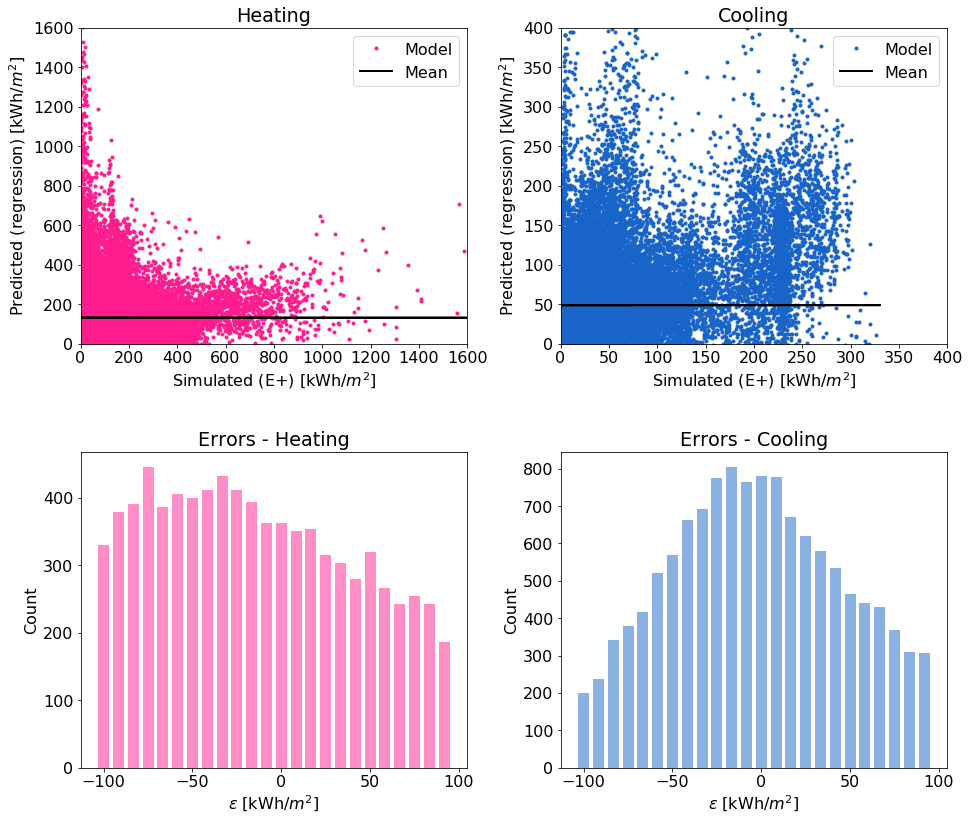

In [142]:
plot_predictions(y_test, y_pred,y_train)

In [143]:
# What if we thought that each input had exactly the same impact on the output?

y_pred = np.NaN*np.ones([y_test.shape[0], 2]) 

for idx, x in enumerate(x_test_scaled):
    y_pred[idx, 0] = (model_random_regr('heatnorm', x, 'fixed'))
    y_pred[idx, 1] = (model_random_regr('coolnorm', x, 'fixed'))

y_pred = pd.DataFrame(scaler_y.inverse_transform(y_pred), columns=['heatnorm', 'coolnorm'])

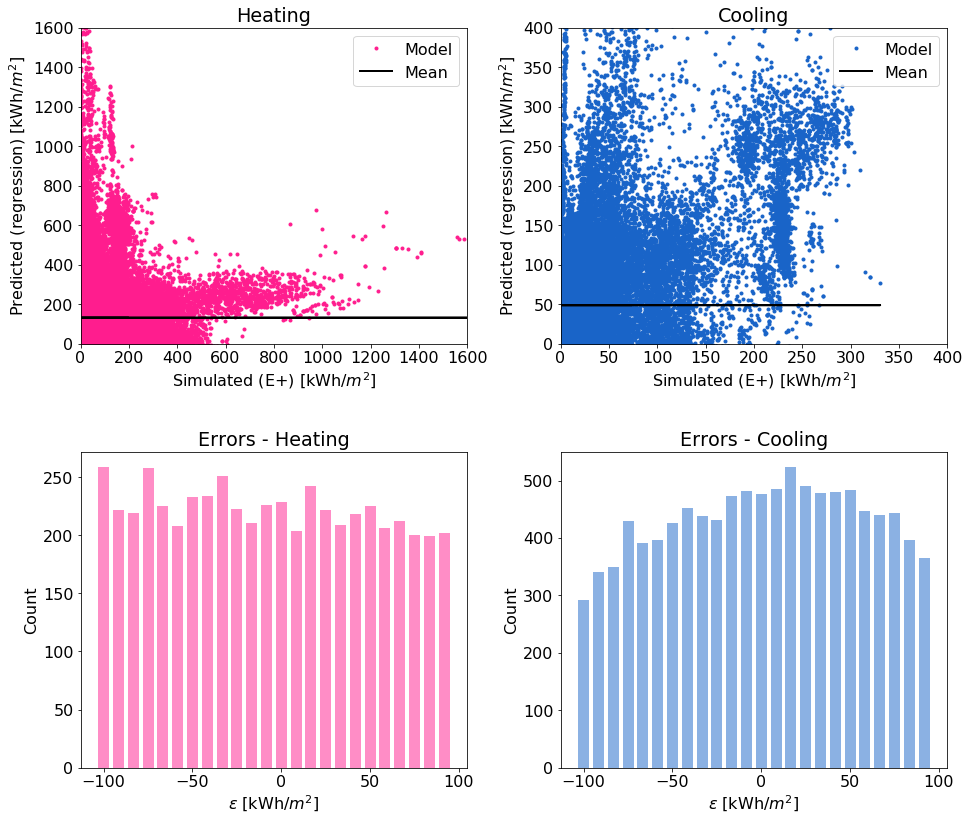

In [144]:
plot_predictions(y_test, y_pred,y_train)

<h2> Aleatory Uncertainty </h2>

<h3>Fixed coefficients, random inputs</h3>

For this exercise, we will learn the coefficients on typical inputs and use these to examine the response of the building to random inputs (varying outdoor or boundary conditions).

In [147]:
# Typical weather only.
x_train_typ = df_eplus.loc[df_eplus.loc[:, 'wthrsrc']=='typical', selected_xvars]
y_train_typ = df_eplus.loc[df_eplus.loc[:, 'wthrsrc']=='typical', ['heatnorm', 'coolnorm']]

# Measured and synthetic weather.
x_test_typ = df_eplus.loc[df_eplus.loc[:, 'wthrsrc']!='typical', selected_xvars]
y_test_typ = df_eplus.loc[df_eplus.loc[:, 'wthrsrc']!='typical', ['heatnorm', 'coolnorm']]

y_pred_typ = dict(heatnorm=None, coolnorm=None)

# Let's fit a second-degree polynomial.
model_poly_typ_features = PolynomialFeatures(2)
x_train_trans = model_poly_typ_features.fit_transform(x_train_typ)
model_poly_typ_regr = dict(heatnorm=LinearRegression(), coolnorm=LinearRegression())
model_poly_typ_regr['heatnorm'].fit(X=x_train_trans, y=y_train_typ['heatnorm'])
model_poly_typ_regr['coolnorm'].fit(X=x_train_trans, y=y_train_typ['coolnorm'])

x_test_trans = model_poly_features.fit_transform(x_test_typ)
y_pred_typ['heatnorm'] = model_poly_typ_regr['heatnorm'].predict(x_test_trans)
y_pred_typ['coolnorm'] = model_poly_typ_regr['coolnorm'].predict(x_test_trans)

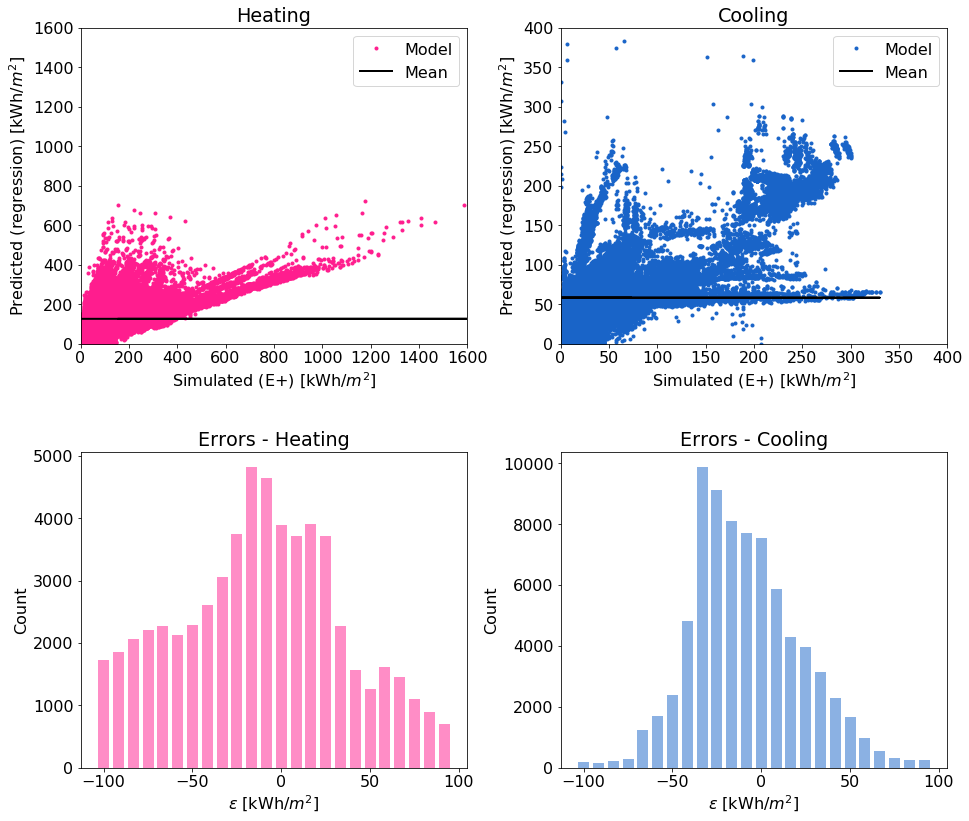

In [149]:
plot_predictions(y_test_typ, y_pred_typ, y_train_typ)

Text(0.5, 28.0, 'y [kWh/$m^2$]')

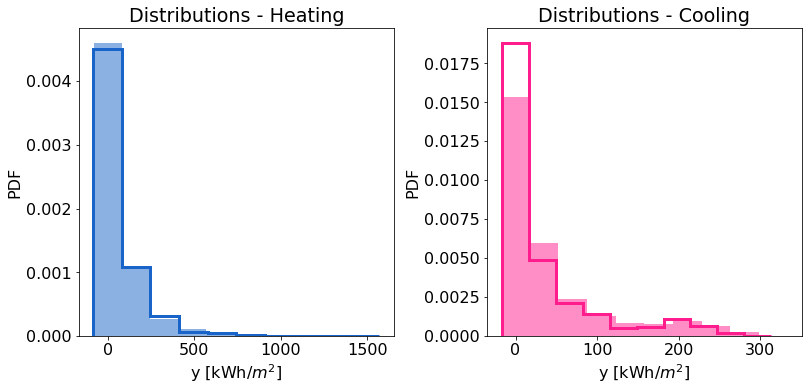

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=3, h_pad=5)

ax[0].hist(y_train_typ['heatnorm'], density=True, color=colours.blue, alpha=0.5,
           align='left')
ax[0].hist(y_test_typ['heatnorm'], density=True, color=colours.blue, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[0].set_title('Distributions - Heating')
ax[0].set_ylabel('PDF')
ax[0].set_xlabel('y [kWh/$m^2$]')

ax[1].hist(y_train_typ['coolnorm'], density=True, color=colours.hotpink, alpha=0.5,
           align='left')
ax[1].hist(y_test_typ['coolnorm'], density=True, color=colours.hotpink, alpha=1,
           histtype='step', align='left', linewidth=3)
ax[1].set_title('Distributions - Cooling')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('y [kWh/$m^2$]')

In [ ]:
# Individual projects.

# Explore an aspect of uncertainty.

<h2>Solar power with random weather inputs</h2>

<strong>Optional</strong>

Use the `solar_power_func` to plot solar power production with random inputs. This function uses the procedure laid out in the iPython notebook: `solar_power`. 

Bonus exercise: optimise tilt and/or orientation angle.

In [ ]:
# I am re-issuing the import commands here so this part stands alone.
# The modules that are already loaded will not reload. 

import os
import glob
import numpy as np
import pandas as pd

import solar_power_func as solar
import wfileio as wf
import default_colours as colours

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
file_type = 'epw'

# I use os.path.join so the paths are automatically constructed based on the OS.
path_epw_ddn = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')

# The small program get_weather stores data from the incoming weather
# file as a dataframe.
ddn, locdata, header = wf.get_weather('ddn', path_epw_ddn, file_type=file_type)

In [ ]:
power = solar.tmy_to_power(path_tmy_data=path_epw_ddn,
                           surface_tilt=30, surface_azimuth=180,
                           albedo=0.2, silent=True)

In [ ]:
plot_x = np.arange(0, ddn.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

In [ ]:
# Do the same with Geneva data. Except Geneva has multiple weather files, so use a loop.
path_gen_folder = os.path.join('..', 'gen', 'historical')
list_genfiles = glob.glob(os.path.join(path_gen_folder, '*.{:s}'.format(file_type)))

# Declare a list.
gen_list = list()

for file in list_genfiles:
    
    gen_temp, locdata, header = wf.get_weather('gen', file, file_type=file_type)
    gen_list.append(gen_temp)
    
# Keep the list - useful for plotting and stuff later.
gen = pd.concat(gen_list)

In [ ]:
power_syn_list = list()

for file in list_genfiles:
    power_syn_list.append(solar.tmy_to_power(path_tmy_data=file,
                                   surface_tilt=30, surface_azimuth=180,
                                   albedo=0.2, silent=True))

power_syn_df = pd.concat(power_syn_list)

In [ ]:
print(power_syn_df.index)

In [ ]:
plot_x = np.arange(0, power_syn_df.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power_syn_df, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

<h2> Bibliography </h2>

<ul>
<li>Rastogi, Parag. 2016. “On the Sensitivity of Buildings to Climate: The Interaction of Weather and Building Envelopes in Determining Future Building Energy Consumption.” PhD, Lausanne, Switzerland: Ecole polytechnique fédérale de Lausanne. EPFL Infoscience. https://infoscience.epfl.ch/record/220971?ln=en.
<li>Rastogi, Parag, and Marilyne Andersen. 2015. “Embedding Stochasticity in Building Simulation Through Synthetic Weather Files.” In Proceedings of BS 2015. Hyderabad, India. http://infoscience.epfl.ch/record/208743.
<li>———. 2016. “Incorporating Climate Change Predictions in the Analysis of Weather-Based Uncertainty.” In Proceedings of SimBuild 2016. Salt Lake City, UT, USA. http://infoscience.epfl.ch/record/208743.
<li>Rastogi, Parag, Mohammad Emtiyaz Khan, and Marilyne Andersen. 2017. “Gaussian-Process-Based Emulators for Building Performance Simulation.” In Proceedings of BS 2017. San Francisco, CA, USA: IBPSA.
<li>Iaccarino, Gianluca. 2008. “Quantification of Uncertainty in Flow Simulations Using Probabilistic Methods.” presented at the VKI Lecture Series, Stanford University, September. http://web.stanford.edu/group/uq/uq_youq.html.
<li>Macdonald, Iain. 2002. “Quantifying the Effects of Uncertainty in Building Simulation.” Doctoral, University of Strathclyde. https://www.strath.ac.uk/media/departments/mechanicalengineering/esru/research/phdmphilprojects/macdonald_thesis.pdf.

</ul>